In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
global_data = pd.read_csv(r"C:\Users\acer pc\OneDrive\Desktop\corona\covid_19_data.csv")
global_data.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [7]:
def smoother(inputdata,w,imax):
    data = 1.0*inputdata
    data = data.replace(np.nan,1)
    data = data.replace(np.inf,1)
    smoothed = 1.0*data
    normalization = 1
    for i in range(-imax,imax+1):
        if i==0:
            continue
        smoothed += (w**abs(i))*data.shift(i,axis=0)
        normalization += w**abs(i)
    smoothed /= normalization
    return smoothed

def growth_factor(confirmed):
    confirmed_iminus1 = confirmed.shift(1, axis=0)
    return (confirmed/confirmed_iminus1)

def growth_ratio(confirmed):
    confirmed_iminus1 = confirmed.shift(1, axis=0)
    return (confirmed/confirmed_iminus1)

def plot_country_active_confirmed_recovery(country):

    country_data = global_data[global_data['Country/Region']==country]
    table = country_data.drop(['SNo','Province/State','Last Update'], axis = 1)
    
    table['ActiveCases'] = table['Confirmed'] - table['Recovered'] - table['Deaths']
    table2 = pd.pivot_table(table, values=['ActiveCases','Confirmed', 'Recovered','Deaths'], index=['ObservationDate'], aggfunc=np.sum)
    table3 = table2.drop(['Deaths'], axis=1)
   
    # Growth Factor
    w = 0.5
    table2['GrowthFactor'] = growth_factor(table2['Confirmed'])
    table2['GrowthFactor'] = smoother(table2['GrowthFactor'],w,5)

    # 2nd Derivative
    table2['2nd_Derivative'] = np.gradient(np.gradient(table2['Confirmed'])) #2nd derivative
    table2['2nd_Derivative'] = smoother(table2['2nd_Derivative'],w,7)


    #Plot confirmed[i]/confirmed[i-1], this is called the growth ratio
    table2['GrowthRatio'] = growth_ratio(table2['Confirmed'])
    table2['GrowthRatio'] = smoother(table2['GrowthRatio'],w,5)
    
    #Plot the growth rate, we will define this as 
    
    # horizontal line at growth rate 1.0 for reference
    x_coordinates = [1, 100]
    y_coordinates = [1, 1]
    #plots
    table2['Deaths'].plot(title='Deaths')
    plt.show()
    table3.plot() 
    plt.show()
    table2['GrowthFactor'].plot(title='Growth Factor')
    plt.plot(x_coordinates, y_coordinates) 
    plt.show()
    table2['2nd_Derivative'].plot(title='2nd_Derivative')
    plt.show()
    table2['GrowthRatio'].plot(title='Growth Ratio')
    plt.plot(x_coordinates, y_coordinates)
    plt.show()

    return 


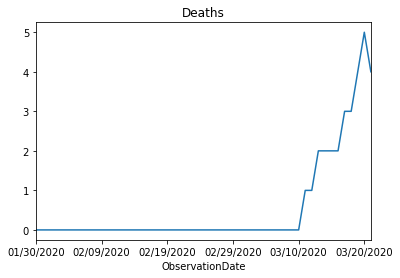

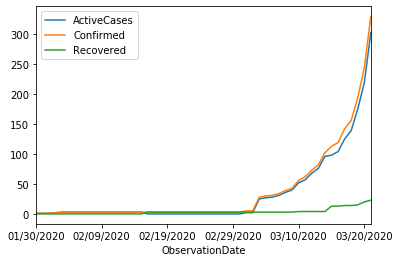

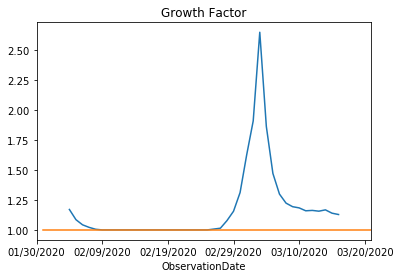

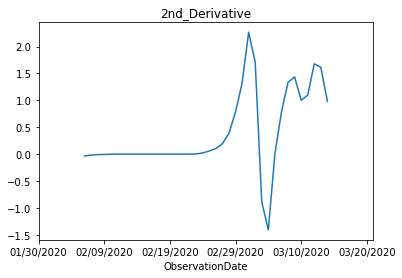

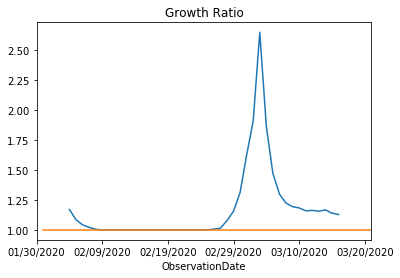

In [9]:
plot_country_active_confirmed_recovery('India')

In [10]:
from scipy.optimize import curve_fit

In [11]:

global_data = pd.read_csv(r"C:\Users\acer pc\OneDrive\Desktop\corona\covid_19_data.csv")
country_data = global_data[global_data['Country/Region']=='Italy']
country_data = country_data.drop(['SNo','Province/State', 'Last Update'], axis=1)
country_data = pd.pivot_table(country_data, values=['Confirmed', 'Recovered','Deaths'], index=['ObservationDate'], aggfunc=np.sum)
country_data.tail()

,Confirmed,Deaths,Recovered
ObservationDate,,,
03/17/2020,31506.0,2503.0,2941.0
03/18/2020,35713.0,2978.0,4025.0
03/19/2020,41035.0,3405.0,4440.0
03/20/2020,47021.0,4032.0,4440.0
03/21/2020,53578.0,4825.0,6072.0


In [12]:
x_data = range(len(country_data.index))
y_data = country_data['Confirmed']

def log_curve(x, k, x_0, ymax):
    return ymax / (1 + np.exp(-k*(x-x_0)))

# Fit the curve
popt, pcov = curve_fit(log_curve, x_data, y_data, bounds=([0,0,0],np.inf))
estimated_k, estimated_x_0, ymax= popt


# Plot the fitted curve
k = estimated_k
x_0 = estimated_x_0
y_fitted = log_curve(x_data, k, x_0, ymax)
print(k, x_0, ymax)
#print(y_fitted)
y_data.tail()

0.19799465290260157 50.790174591908894 114436.61136399607


ObservationDate
03/17/2020    31506.0
03/18/2020    35713.0
03/19/2020    41035.0
03/20/2020    47021.0
03/21/2020    53578.0
Name: Confirmed, dtype: float64

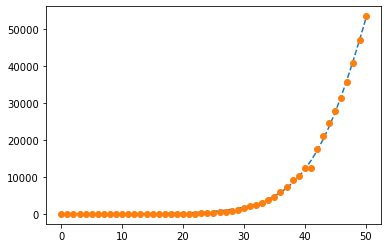

In [13]:
# Plot everything for illustration
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_data, y_fitted, '--', label='fitted')
ax.plot(x_data, y_data, 'o', label='Confirmed Data')

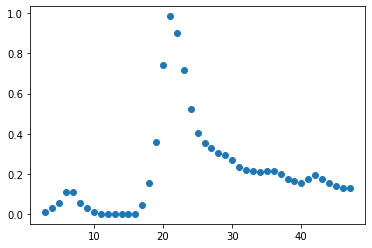

In [14]:
country_data['GrowthRate']=np.gradient(np.log(country_data['Confirmed']))
ydata = smoother(country_data['GrowthRate'],0.5,3)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_data, ydata, 'o', label='Confirmed Data')